In [304]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from itertools import groupby

from datetime import datetime, timedelta
#import tabulate
#import csv
from dateutil import parser


Data Retrieval

In [305]:

# Connect to Google
# Scope: Enable access to specific links
scope = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive"]

credentials = ServiceAccountCredentials.from_json_keyfile_name("./gscredentials.json", scope)

client = gspread.authorize(credentials)

# Open the Google Sheet
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'

sheet = client.open_by_key(sheet_id)

worksheet = sheet.get_worksheet(0)  # Assuming you want to work with the first worksheet

global_data = worksheet.get_all_values()

#names = [row[0] for row in data[1:]]  # Assuming first row contains headers


Data Structures

In [306]:
class TreeNode:
    def __init__(self, name):
            self.name = name
            self.value = None
            self.children = []
            self.parent = None
    def add_child(self, child):
          child.parent = self
          self.children.append(child)
    def print_tree(self):
        prefix = '-'*self.get_level()
        print(prefix + self.name + ", " + str(self.value))
        if len(self.children) > 0:
            for child in self.children:
                child.print_tree()
    def get_level(self):
        if self.parent == None:
            return 0
        level = self.parent.get_level() + 1
        return level
    def get_child(self, name):
        for child in self.children:
            if child.name == name:
                return child

#takes in the database and the tree heirarchy
def build_user_tree(data):
     users = TreeNode("users")
     #iterates through each row of data, skipping over the headers, using the timestamp as a marker of a data entry
     i=1
     while(data[i][0] != ''):
        #compares each row of data if it matches any existing user, row  is the email
        entry = create_data_entry(data[i])
        if user_match(data[i],users):
             #adds this row to the tree of data
             user_match(data[i],users).get_child("data").add_child(entry)
        else:
             #create and append a user to an existing tree of users
             user = create_new_user(users)
             users.add_child(user)
             user.value = data[i][1]
             user.get_child("data").add_child(entry)
        i+=1
     return users
        
def user_match(row,users):
     if len(users.children) == 0:
        return 0
     for user in users.children:
        if row[1] == user.value:
            return user
     return 0
    
def create_data_entry(row):
    #if there is no timestamp, don't do it
    if row[0] != '':
        entry = TreeNode("entry")
        timestamp = TreeNode("timestamp")
        timestamp.value = (row[0])
        entry.add_child(timestamp)

        #make sure "workout" or '' do not show up. You can't check for type != string since all responses are str
        if row[2] != '' and row[2] != "workout":
            body_weight = TreeNode("body_weight")
            body_weight.value = (float(row[2]))
            entry.add_child(body_weight)
            last_body_weight = row[2]
        else:
        #make sure that this is not an entry for a weight
        #if row[2] == "workout" and type(row[2]) != float and type(row[2]) != int:
            activity = TreeNode("activity")
            activity.value = row[3]
            entry.add_child(activity)

            # finish this later
            variants = TreeNode("variants")
            
            entry.add_child(variants)

            #if row[7] != '': # this shouldn't be necessary
            resistance_type = TreeNode("resistance_type")
            resistance_type.value = row[5]
            entry.add_child(resistance_type)



            if row[6] != '': # this shouldn't be necessary
                set_n = TreeNode("set_n")
                set_n.value = int(row[6])
                entry.add_child(set_n)

            if row[8] != '': # this shouldn't be necessary
                reps = TreeNode("reps")
                reps.value = int(row[8])
                entry.add_child(reps)

            if row[7] != '':
                weight = TreeNode("weight")
                #calisthenics and rings
                date_format = "%m/%d/%Y %H:%M:%S"

                # Parse the date string into a datetime object
                date_obj = datetime.strptime(row[0], date_format)
                date = date_obj.timestamp()
                if row[5] == "calisthenic" or row[5] == "Rings": # this shouldn't be necessary
                    weight.value = float(row[7])#+ float(get_bw_by_date("user0", date))

                else: 
                    weight.value = float(row[7])
                entry.add_child(weight)

            if row[9] != '':
                rpe = TreeNode("rpe")
                rpe.value = int(row[9])
                entry.add_child(rpe)
            
            if row[2] == '' or row[2] == 'workout':
                derived = TreeNode("derived")
                tags = TreeNode("tags")
                muscles = TreeNode("muscles")
                volume = TreeNode("volume")
                volume.value = calc_volume(row)
                tags.value = categorize(row)[0]
                muscles.value = categorize(row)[1]

                derived.add_child(tags)
                derived.add_child(muscles)
                derived.add_child(volume)
                entry.add_child(derived)
            
    return entry
def calc_volume(row):
    bw = 155
    volume =0
    if row[5] == "calisthenic" or row[5] == "Rings" or row[7] == '' or row[8] == '':
        #print(row)
        added_weight = 0
        if row[7] != '':
            added_weight = float(row[7])

        volume = (bw + added_weight)*float(row[8])
        #add weighted factor to calisthenics
        #row[7] = bw #+ float(row[7])
    else:
        
        volume = float(row[7])*float(row[8])
    # account for two-arm, dumbells, pull up, and whatever else
    
    return volume

def create_new_user(users):
    user = TreeNode("user"+str(len(users.children)))
    data = TreeNode("data")
    name = TreeNode("name")
    user.add_child(data)
    user.add_child(name)
    return user

def filter_helper(input, method, criteria, index):
    #print(criteria)
    #print(input)
    output = []
    if method == "string":
        for entry in input:
            for name in criteria:
                if type(entry[index]) != str:
                    continue
                #skips non-strings
                if entry[index] == name:
                    output.append(entry)
                else:
                    continue
    elif method == "numerical":
        #make error case when prompted with ranges that overlap
        for entry in input:
            for range in criteria:
                #print(entry)
                if type(entry[index]) == str:
                    entry[index] = float(entry[index])
                if entry[index] >= range[0] and entry[index] <= range[1]:
                    output.append(entry)
                else:
                    continue
    elif method == "time":
        for entry in input:
            for range in criteria:
                #print(entry)
                if type(entry[index]) == str:
                    date = float(datetime.strptime(entry[index], '%m/%d/%Y %H:%M:%S').timestamp())
                    #entry[index] = float(entry[index])
                if date >= range[0] and date <= range[1]:
                    output.append(entry)
                else:
                    continue
    elif method == "variants":
        for entry in input:
            for lists in criteria:
                for name in lists:
                    if entry[index] == name:
                        output.append(entry)
                    else:
                        continue
                    
    else: 
        output = input
        print("error in filter function, no filter applied. criteria: " + criteria)
        
    return output

def filter_entries(input, criteria_type, criteria):
    #input is a table of data, 2D array
    #criteria type is what you are discriminating against
    #the criteria parameter itself is expected to be a list of ranges, so a list of a list being a 2D array as well.

    match criteria_type:
        case 'users':
            output = filter_helper(input, "string", criteria, 1)
        case 'time_ranges':
            #print(input)
            #input = float(datetime.strptime(input, '%m/%d/%Y %H:%M:%S').timestamp())
            #print(input)
            output = filter_helper(input, "time", criteria, 0)
        #note that this uses the same row of data for bodyweight
        case 'workout':
            output = filter_helper(input, "string", criteria, 2)
        case 'body_weight_ranges':
            output = filter_helper(input, "numerical", criteria, 2)
        case 'activities':
            output = filter_helper(input, "string", criteria, 3)
        case 'variants':
            output = filter_helper(input, "variants", criteria, 4) # ideally you want to make another method for this filter
        case 'resistance_types':
            output = filter_helper(input, "string", criteria, 5)
        case 'set_n_ranges':
            output = filter_helper(input, "numerical", criteria, index=6)
        case 'rep_ranges':
            output = filter_helper(input, "numerical", criteria, 8)
        case 'weight_ranges':
            output = filter_helper(input, "numerical", criteria, 7)
        case _:
            print("no filter criteria recognized!")

    return output

def categorize(entry):
    if entry[2] == '' or entry[2] == 'workout':
        tags = set()
        muscles = set()
        match entry[3]:
            case 'squat':
                tags.add("Legs")
                tags.add("Compound")

                muscles.add("quadriceps")
                muscles.add("hamstrings")
            case 'Bench':
                tags.add("Compound")
                tags.add("Push")

                muscles.add("pectorals")
                muscles.add("anterior deltoids")
                muscles.add("triceps")
            case 'Deadlift':
                tags.add("Compound")
                tags.add("Legs")

                muscles.add("quadriceps")
                muscles.add("hamstrings")
                muscles.add("latissimus dorsi")
                muscles.add("trapezius")
            case 'overhead press': 
                tags.add("Compound")
                tags.add("Push")

                muscles.add("anterior deltoids")
                muscles.add("triceps")
            case 'tricep pull':
                tags.add("Arms")
                tags.add("Push")

                muscles.add("triceps")
            case 'bicep curl':
                tags.add("Arms")
                tags.add("Pull")

                muscles.add("biceps")
            case 'hammer curl':
                tags.add("Arms")
                tags.add("Pull")

                muscles.add("biceps")
            case 'RDL':
                tags.add("Compound")
                tags.add("Pull")

                muscles.add("latissimus dorsi")
                muscles.add("trapezius")
                muscles.add("biceps")
            case 'lateral raise':
                tags.add("Push")

                muscles.add("lateral deltoids")
            case 'shoulder shrugs':
                tags.add("Pull")

                muscles.add("trapezius")
            case 'row':
                tags.add("Pull")

                muscles.add("latissimus dorsi")
                muscles.add("trapezius")
                muscles.add("biceps")
            case 'lat pullown':
                tags.add("Pull")

                muscles.add("latissimus dorsi")
                muscles.add("biceps")
            case 'rear delt':
                tags.add("Pull")

                muscles.add("posterior deltoids")
            case 'skull crusher':
                tags.add("Arms")
                tags.add("Push")

                muscles.add("triceps")
            case 'pull up':
                tags.add("Compound")
                tags.add("Pull")

                muscles.add("latissimus dorsi")
                muscles.add("biceps")
            case 'chin up':
                tags.add("Compound")
                tags.add("Pull")

                muscles.add("latissimus dorsi")
                muscles.add("biceps")
            case 'dips':
                tags.add("Compound")
                tags.add("Push")

                muscles.add("pectorals")
                muscles.add("anterior deltoids")
                muscles.add("triceps")
            case 'push up':
                tags.add("Compound")

                muscles.add("pectorals")
                muscles.add("anterior deltoids")
                muscles.add("triceps")
            case 'face pull':
                tags.add("Pull")

                muscles.add("latissimus dorsi")
                muscles.add("trapezius")
                muscles.add("biceps")
            case 'bulgarians':
                tags.add("Compound")
                tags.add("Legs")
            case 'Chest fly':
                tags.add("Push")

                muscles.add("pectorals")
            case 'Leg abduction':
                tags.add("Legs")

                muscles.add("abductors")
            case 'Leg adduction':
                tags.add("Legs")

                muscles.add("adductors")
            case _: 
                print("default case evoked")
        
        return tags, muscles
    else: 
        #print("error in categorization on entry, or bodyweight")
       
        return {}, {}


if __name__ == '__main__':
    users = build_user_tree(global_data)
    users.print_tree()
    pass

#create second pass for derived data
#for user in users.children:
    

default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked
default case evoked


Data Analysis

In [307]:

def get_coord_pairs_from_user(user, criteria, unix_output):
    coord_pairs = []
    x = []
    currx = 0
    y = []
    for child in users.get_child(user).get_child("data").children:
        if child.get_child(criteria):
            if unix_output == True:
                currx = int(datetime.strptime(child.get_child("timestamp").value, '%m/%d/%Y %H:%M:%S').timestamp())
                x.append(currx)
            else:
                currx = datetime.strptime(child.get_child("timestamp").value, '%m/%d/%Y %H:%M:%S')
                x.append(currx)
            y.append(child.get_child(criteria).value)
            coord_pairs.append([currx, child.get_child("body_weight").value])
    return coord_pairs, x, y

def get_data_from_entries(data, criteria1, criteria2, data_type1, data_type2):
    #enumerate, for now its just indecies
    coord_pairs = []
    x = []
    y = []
    for entry in data:

        x.append(match_data_type(entry[criteria1], data_type1))
        y.append(match_data_type(entry[criteria2], data_type2))
        coord_pairs.append([match_data_type(entry[criteria1], data_type1), match_data_type(entry[criteria2], data_type2)])
              
    return coord_pairs, x, y

def match_data_type(input, data_type):
    match data_type:
        case "int":
            return int(input)
        case "float":
            return float(input)
        case "list":
            print("list type invoked! leaving data as is")
            return input
        case _:
            #leave as string
            return str(input)

def calculate_prediction_intervals(Set, y_model, dynamic, confidence_level, y_fit_original_size=[]):


    if len(y_fit_original_size) == 0:
        y_fit_original_size = y_model
    

    alpha = 1-confidence_level
    
    y = []
    x = []
    for pair in Set:
        x.append(pair[0])
        y.append(pair[1])

    if dynamic:
        #let's try to model the error as a set of data, and use that to create dynamic confidence intervals
        standard_errors = []
        for i in range(len(y)):

            standard_errors.append([x[i], std_err(y[i], y_model[i])])

        polynomial_degree = 4
        std_error_curve = fit_curve(standard_errors, polynomial_degree, linspace="default")

        prediction_intervals = []

        for i in range(len(y)):
            
            critical_value = stats.t.ppf(1 - alpha/2, df=len(y_model)-1)
            print("crit", critical_value)
            print("std_err", std_error_curve[i])
            print("y-model", y_model[i])
            lower_bound = y_model[i] - (critical_value * std_error_curve[i])
            upper_bound = y_model[i] + (critical_value * std_error_curve[i])
            prediction_intervals.append((lower_bound, upper_bound))
        return prediction_intervals

        #lower_bound = y_model + std_error_curve
        #upper_bound = y_model + std_error_curve
        #return lower_bound, upper_bound
    
    else:
        #use the mean of the entire errors to model the confidenc intervals statically
        # assume size of y_model = size of x


        mse = mean_squared_error(y, y_fit_original_size)

        # Calculate the standard error
        standard_error = np.sqrt(mse)
        # Assuming 95% confidence level (alpha = 0.05)
        
        
        prediction_intervals = []

        for i in range(len(y_model)):
        
            critical_value = stats.t.ppf(1 - alpha/2, df=len(y_model)-1)
            lower_bound = y_model[i] - (critical_value * standard_error)
            upper_bound = y_model[i] + (critical_value * standard_error)
            prediction_intervals.append((lower_bound, upper_bound))
        return prediction_intervals

# for individual points
def std_err(y1, y2):
    return np.sqrt(np.square((y1-y2)/2))


def fit_curve(Set, degree, linspace="default"):
    y = []
    x = []
    output = []

    for pair in Set:
        if type(pair[0]) == datetime:
            x.append(int(pair[0].timestamp()))
        else:
            x.append(pair[0])
        y.append(pair[1])
    # Fit a polynomial of specified degree
    coeffs = np.polyfit(x, y, degree)
    if type(linspace) == str:
        linspace = x
    # Generate y values based on the fitted polynomial
    y_fit = np.polyval(coeffs, linspace)

    for i in range(len(linspace)):
        output.append([linspace[i], y_fit[i]])
    
    return output, linspace, y_fit

def pareto(data):
    x = []
    y = []
    z = []
    for element in data:
        x.append(element[0])
        y.append(element[1])
        z.append(element[0]*element[1])

    output = set(find_maxes(data, 1)).union(find_maxes(data, 0))
    output = find_maxes(output, 1)

    return output
#pareto-like max values for each bench
def unique_in_set(x, set):
    if len(set) > 0:
        for element in set:
            if x == element:
                if type(x) != type(element):
                    print("types do not match")
                return False
        return True
    else: 
        return True
    
    #probably should have used sets tbh
def make_unique(set, respect):
    #assumes 1d
    # need to unpack
    unpacked = []
    
    for element in set:
        unpacked.append(element[respect])
    
    unique_set = []
    for element in set:
        if unique_in_set(element[respect], unique_set):
            unique_set.append(element[respect])  
    return unique_set

def find_maxes(data, respect):
    # assumes 2d respect is which coordinate of the pair with respect to
    # set(x, y): 
    # maxes with respect to y would be finding unique values in y
    # then finding the max values of x for each y
    # given a rep range, find the largest weight for it
    maxes = set()
    #make the set of the other var unique
    unique_split_set = set()
    for element in data:
        unique_split_set.add(element[respect^1])
    
    # stopped using below because i discovered sets
    #unique_split = make_unique(data, respect ^ 1)
    for unique in unique_split_set:
        max = 0
        for element in data:
            if element[respect ^ 1] == unique:
                if element[respect] > max:
                    max = element[respect]
        if respect == 0:
            maxes.add((max, unique))
        else:
            maxes.add((unique, max))
    return maxes


def group_data_by_date2(data, date, grouping="daily"):
    # Convert date strings to datetime objects
    date_objects = [datetime.strptime(d, '%m/%d/%Y %H:%M:%S') for d in date]
    # print(date_objects)

    # Combine data, date, and date objects into tuples
    combined_data = list(zip(date, date_objects, data))
    
    # Sort the combined data by date object
    sorted_data = sorted(combined_data, key=lambda x: x[1])

    # Group data by date
    grouped_data = {key: [item[2] for item in group] for key, group in groupby(sorted_data, key=lambda x: x[1])}

    # Convert grouped data to list of lists
    result = [[date.strftime('%m/%d/%Y %H:%M:%S'), values] for date, values in grouped_data.items()]
    return result

def group_data_by_timestamp(data, dates, grouping='day'):
    grouped_data = {}

    for i, date in enumerate(dates):
        date_obj = datetime.strptime(date, '%m/%d/%Y %H:%M:%S')
        #print(date_obj)
        if grouping == 'day':
            group_key = int((date_obj - datetime(1970, 1, 1)) / timedelta(seconds=1))
        elif grouping == 'week':
            # Get the first day of the week
            first_day_of_week = date_obj - timedelta(days=date_obj.weekday())
            group_key = int((first_day_of_week - datetime(1970, 1, 1)) / timedelta(seconds=1))
        elif grouping == 'month':
            # Get the first day of the month
            first_day_of_month = datetime(date_obj.year, date_obj.month, 1)
            group_key = int((first_day_of_month - datetime(1970, 1, 1)) / timedelta(seconds=1))
        elif grouping == 'year':
            # Get the first day of the year
            first_day_of_year = datetime(date_obj.year, 1, 1)
            group_key = int((first_day_of_year - datetime(1970, 1, 1)) / timedelta(seconds=1))
        else:
            raise ValueError("Invalid grouping option. Use 'day', 'week', 'month', or 'year'.")

        if group_key not in grouped_data:
            grouped_data[group_key] = []

        grouped_data[group_key].append(data[i])

        result = []
        for key, value in grouped_data.items():
            result.append([key, value])

    return result

def get_first_day_of_week(year, week):
    first_day = datetime.strptime(f'{year}-{week}-1', "%Y-%U-%w")
    return first_day

def group_data_by_date(data, timestamps, grouping='day'):
    # Combine data, timestamps, and datetime objects into tuples
    combined_data = list(zip(timestamps, [datetime.fromtimestamp(ts) for ts in timestamps], data))
    
    # Sort the combined data by timestamp
    sorted_data = sorted(combined_data, key=lambda x: x[1])

    # Define a function to get the grouping key based on grouping level
    def get_grouping_key(date_obj):
        if grouping == 'day':
            return date_obj.strftime('%Y-%m-%d')
        elif grouping == 'week':
            year, week, _ = date_obj.isocalendar()
            first_day = get_first_day_of_week(year, week)
            return first_day.strftime('%Y-%m-%d')
        elif grouping == 'month':
            return date_obj.strftime('%Y-%m')  # Year-month format
        elif grouping == 'year':
            return date_obj.strftime('%Y')

    # Group data by timestamp
    grouped_data = {key: [item[2] for item in group] for key, group in groupby(sorted_data, key=lambda x: get_grouping_key(x[1]))}

    # Convert grouped data to list of lists
    result = [[timestamp, values] for timestamp, values in grouped_data.items()]

    return result



def get_bw_by_date(user, date):
    #data = filter_entries(global_data[1:], "users", [user])
    #data = filter_entries(data, "", [user])
    coords = get_coord_pairs_from_user(user, "body_weight", True)[0]

    fit = fit_curve(coords, 2, linspace="default")[0]
    
    closest_pair = []

    for pair in fit:
        if len(closest_pair) != 0:
            if abs(date-pair[0]) < abs(date-closest_pair[0]):
                closest_pair[0] = pair[0]
                closest_pair[1] = pair[1]
        else:
            # initial pair
            closest_pair.append(pair[0])
            closest_pair.append(pair[1])
            #closest_pair[0] = pair[0]
            #closest_pair[1] = pair[1]
    return closest_pair[1]

Plotting

default case invoked! assuming weight lbs
default case invoked! assuming weight lbs


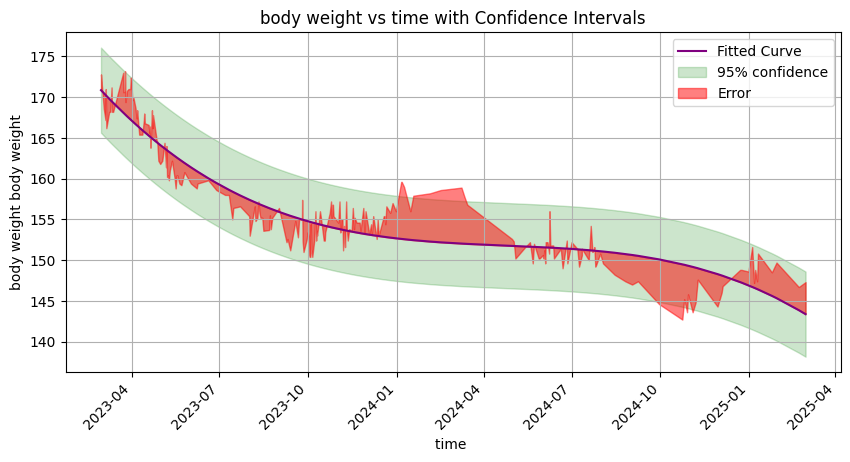

[(135.0, 12), (155.0, 8), (179.0, 4), (185.0, 4)]
[14.08956805 13.71199566 13.34022779 12.97426444 12.61410562 12.25975132
 11.91120154 11.56845629 11.23151555 10.90037935 10.57504766 10.2555205
  9.94179785  9.63387974  9.33176614  9.03545707  8.74495252  8.46025249
  8.18135699  7.90826601  7.64097955  7.37949761  7.1238202   6.87394731
  6.62987895  6.3916151   6.15915578  5.93250098  5.71165071  5.49660495
  5.28736372  5.08392702  4.88629483  4.69446717  4.50844403  4.32822542
  4.15381132  3.98520175  3.82239671  3.66539618  3.51420018  3.3688087
  3.22922174  3.09543931  2.9674614   2.84528801  2.72891915  2.61835481
  2.51359499  2.41463969]


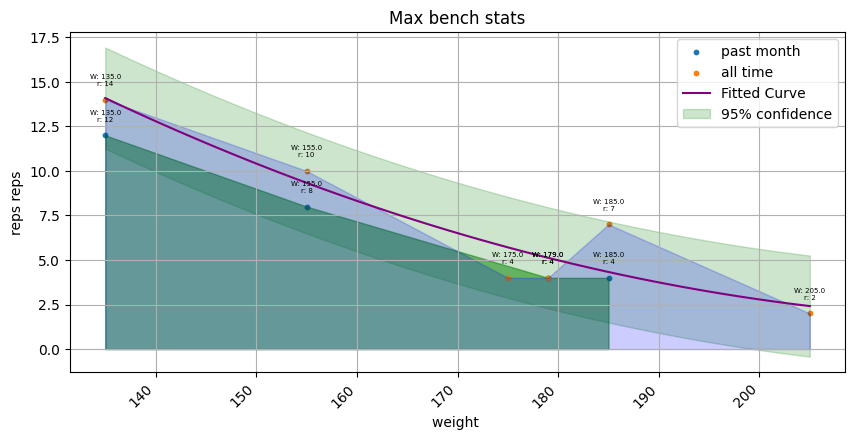

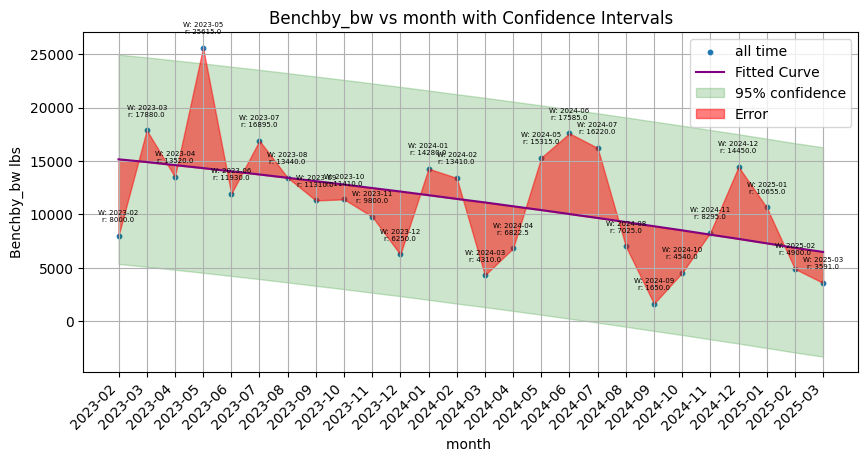

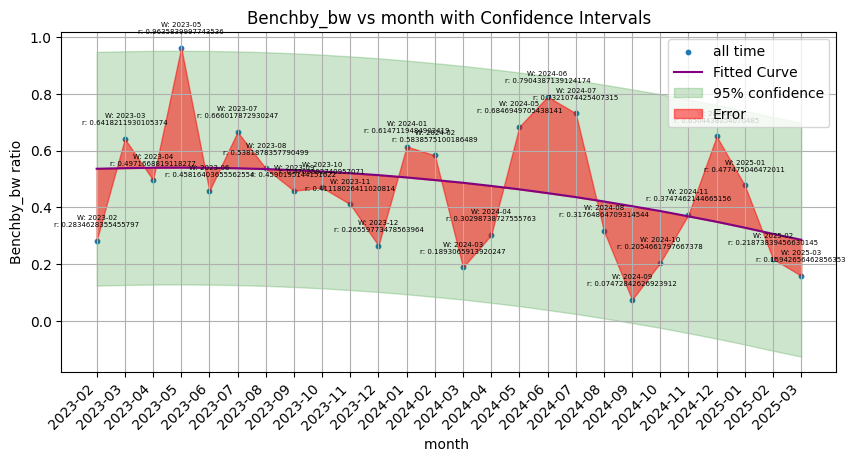

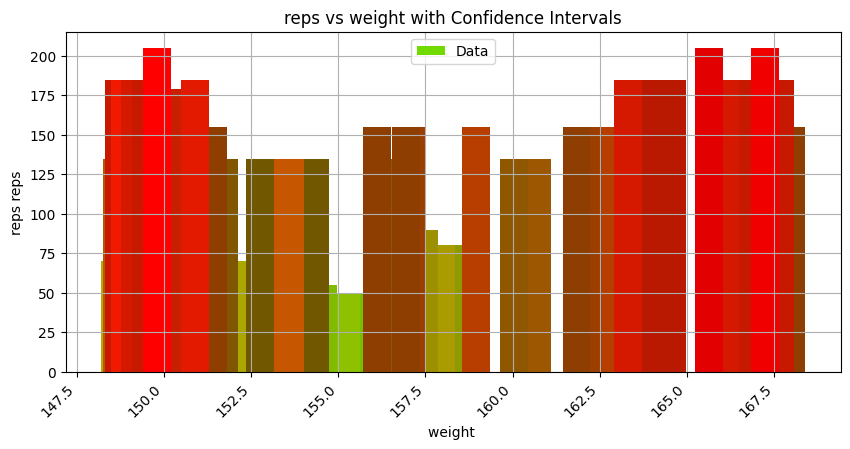

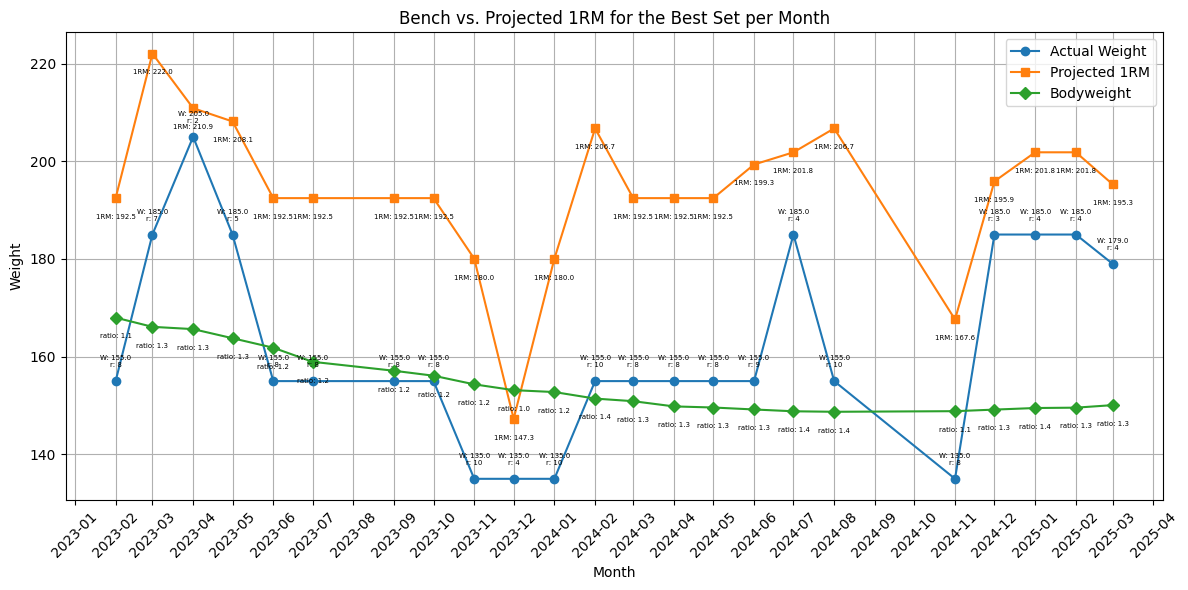

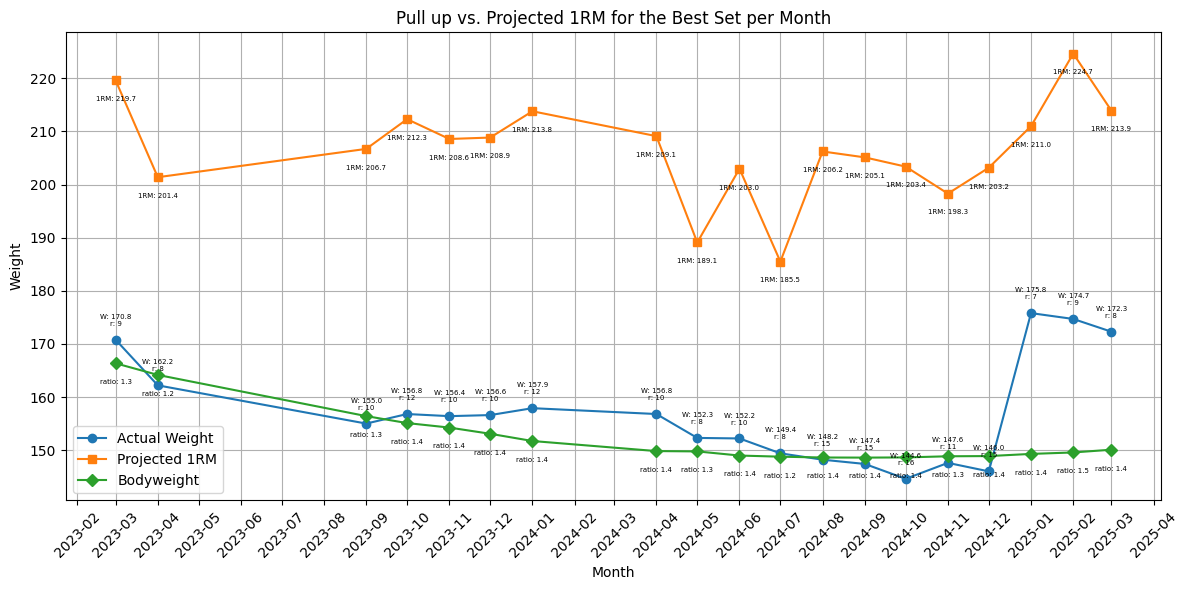

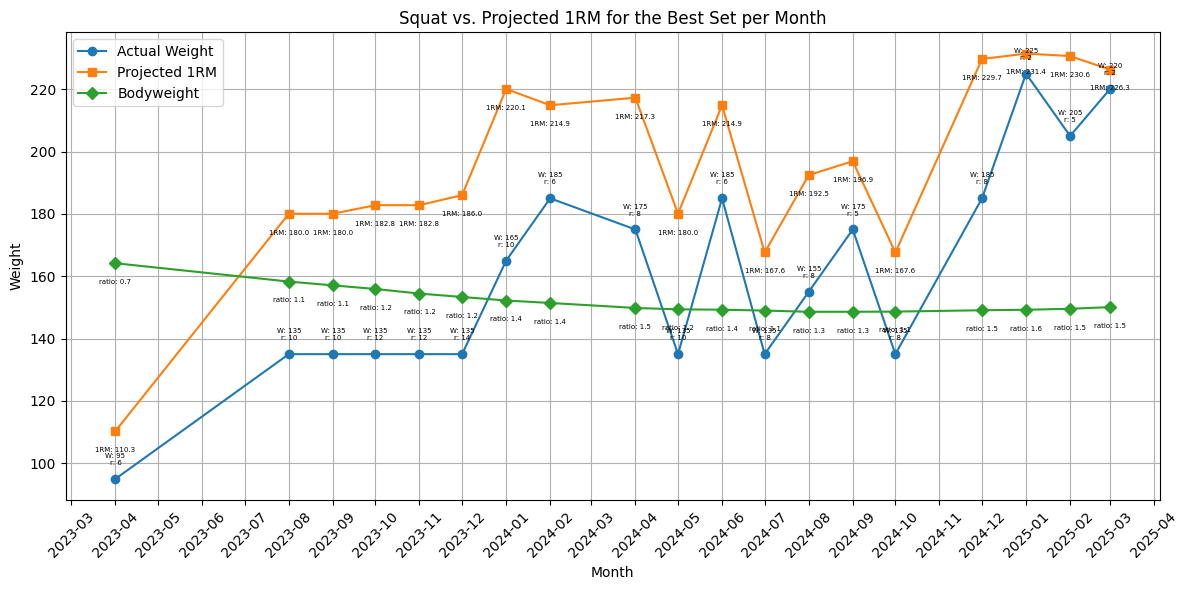

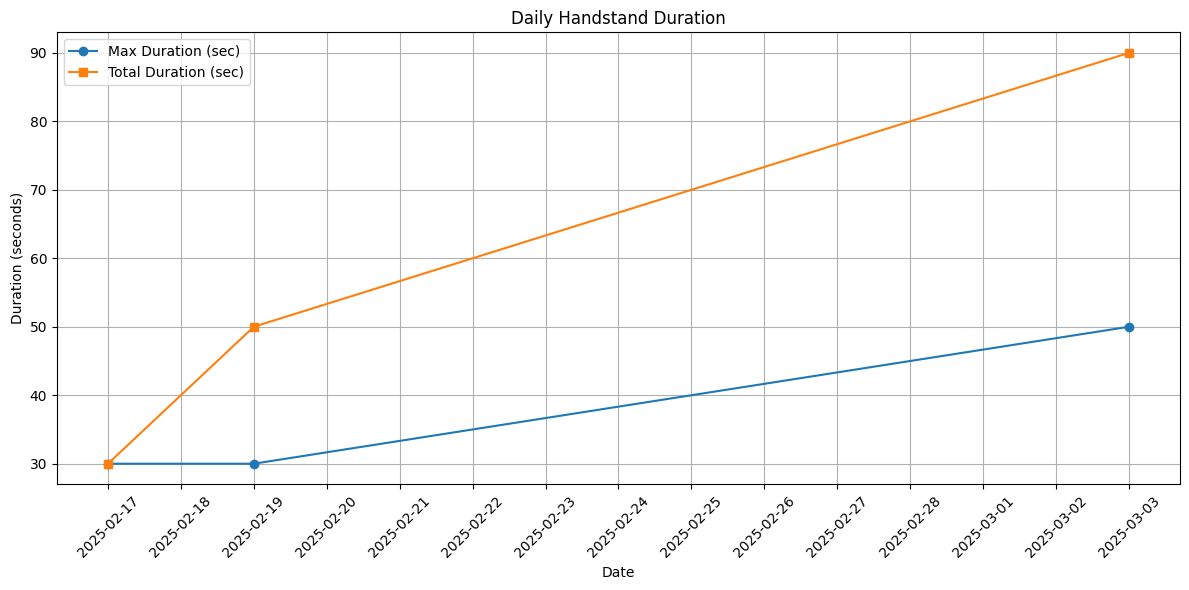

Distinct days trained Handstand in last 7 days: 1


In [308]:
# Plotting
def get_graph_details(unit):
    if unit == "lbs":
        label = "weight"
    elif unit == "#":
        label = "# of "
    elif unit == "reps":
        label = "reps"
    else: 
        label = unit
        print("default case invoked! assuming weight lbs")
    return label

# given a set of data, and following attributes, plot them
def plot_desired_data(x_unit, y_unit, data_set, polynomial_degree=0, confidence_level=0, scatter=False, workout=False, all_sets=[], selection_details=[], bar=False, barcolors=[], title=""):
    # data_set is a 2D array, polynomial_degree is a natural number, confidence_level is a float between 0 < x < 1
    x_label = "x"
    y_label = "y"
    y = []
    x = []
    unix_data_set = []

    for pair in data_set:
        if x_unit == "time":
            #this assumes unix time-form
            if type(pair[0]) == int:
                dt_object = datetime.fromtimestamp(pair[0])
                x.append(dt_object)

                # if the original time was in unix, leave it as be
                unix_data_set.append((pair[0],pair[1]))

            # this is for date-time objects to unix data set for the discrete functions y_fit
            else: 
                timestamp = parser.parse(pair[0])
                unix_data_set.append((timestamp.timestamp(),pair[1]))
                x.append(pair[0])
        # this is not a time-based unit, just proceed
        else:
            unix_data_set.append((pair[0],pair[1]))
            x.append(pair[0])
        y.append(pair[1])
        
            
    if selection_details!=[]:
        x_label = selection_details[3]
        y_label = selection_details[2]+selection_details[4]
    else:
        x_label = get_graph_details(x_unit)
        y_label = get_graph_details(y_unit)
    if polynomial_degree!=0:
        #obtain curve of best fit
        if x_unit == "time":
            y_fit = fit_curve(unix_data_set, polynomial_degree, linspace="default")[2]
            #print(y_fit)
        else:
            y_fit = fit_curve(unix_data_set, polynomial_degree, linspace = np.linspace(np.min(x), np.max(x), 50))[2]
            print(y_fit)
        y_fit_original_size = fit_curve(unix_data_set, polynomial_degree, linspace="default")[2]
        
        #print(data_set)
        #print(x, y)

        # Calculate prediction intervals
        upper = []
        lower = []

        for interval in calculate_prediction_intervals(unix_data_set, y_fit, False, confidence_level, y_fit_original_size):
            lower.append(interval[0])
            upper.append(interval[1])
    
    # this is causing type errors, kinda useless anyway
    #for interval in calculate_prediction_intervals(data_set, y_fit, True, confidence_level):
    #    lower_dynamic.append(interval[0])
    #    upper_dynamic.append(interval[1])

    # Create the plot
    plt.subplots(figsize=(10, 5))

    #make step reps graph

    if len(all_sets) > 0:
        for set_n in all_sets:
            step_x = []
            step_y = []
            for pair in set_n:
                step_x.append(pair[0])
                step_y.append(pair[1])
                plt.annotate(f"W: {pair[0]}\nr: {pair[1]}",
                    (pair[0], pair[1]),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)
        plt.scatter(step_x, step_y, label='past month', s=10)
        plt.fill_between(step_x, 0, step_y, color='green', alpha=0.5)
    
    # for _, row in monthly_max.iterrows():
    #     plt.annotate(f"W: {row['weight']}\nr: {int(row['reps'])}",
    #                 (row['month_start'], row['weight']),
    #                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)
    #     plt.annotate(f"1RM: {row['predicted_1rm']:.1f}",
    #                 (row['month_start'], row['predicted_1rm']),
    #                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=5)
    #     plt.annotate(f"ratio: {row['predicted_1rm']/row['bodyweight']:.1f}",
    #                 (row['month_start'], row['bodyweight']),
    #                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=5)

    if scatter == True:
        plt.scatter(x, y, label='all time', s=10)
        for pair in data_set:
            plt.annotate(f"W: {pair[0]}\nr: {pair[1]}",
                (pair[0], pair[1]),
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)
    if bar == True:
        bar_width = 0.35
        plt.bar(x, y, label='Data', color=barcolors)
        
    if confidence_level>0:
        if len(x) != len(y_fit):
            x1 = np.linspace(np.min(x), np.max(x), len(y_fit))
            plt.plot(x1, y_fit, color='purple', label='Fitted Curve')
            plt.fill_between(x1, lower, upper, color='green', alpha=0.2, label='95% confidence')
            #plt.fill_between(x1, y, y_fit, color='red', alpha=0.5, label='Error')
        else:
            plt.plot(x, y_fit, color='purple', label='Fitted Curve')
            plt.fill_between(x, lower, upper, color='green', alpha=0.2, label='95% confidence')
            plt.fill_between(x, y, y_fit, color='red', alpha=0.5, label='Error')
    #if workout == True:
    #y_unit = "(lbs)"
    x_unit = ""
    plt.xlabel(x_label + ' ' + x_unit)
    plt.gcf().autofmt_xdate()
    plt.ylabel(y_label + ' ' + y_unit)
    if title == "":
        plt.title(y_label + ' vs ' + x_label + ' with Confidence Intervals')
    else:
        plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    if workout == True:
        plt.fill_between(x, 0, y, color='blue', alpha=0.2, label='weight')
    #else:
    #    plt.plot(x, y, 'g')
    #plt.fill_between(x, lower_dynamic, upper_dynamic, color='orange', alpha=0.5, label='Confidence Interval')
    plt.show()

data = get_coord_pairs_from_user("user0", "body_weight", True)[0]
plot_desired_data("time", "body weight", data, 3, .95, False)

steve_data = filter_entries(global_data[1:], "users", ["sdimov77@gmail.com"])

steve_data = filter_entries(steve_data, "activities", ["Bench"])

steve_data = filter_entries(steve_data, "variants", [["straight"]])

#remove warm up sets
steve_data = filter_entries(steve_data, "weight_ranges", [[135,999]])

steve_data = filter_entries(steve_data, "resistance_types", ["barbell"])

data = get_data_from_entries(steve_data, 7, 8, "float", "int")[0]

seconds_in_month = 30 * 24 * 60 * 60 * 3 # 30 days-> 3 months
now = datetime.now()
unix_now = int(now.timestamp())

recent_data = filter_entries(steve_data, "time_ranges", [[unix_now-seconds_in_month, unix_now]])




recent = get_data_from_entries(recent_data, 7, 8, "float", "int")[0]
recent = pareto(recent)
recent = sorted(recent, key=lambda x: x[0])
print(recent)

# print(data)
# set_2 = filter_entries(steve_data, "set_n_ranges", [[2,2]])
# # print(set_2)
# set_2 = get_data_from_entries(set_2, 7, 8, "float", "int")[0]
# set_2 = pareto(set_2)
# set_2 = sorted(set_2, key=lambda x: x[0])

# set_3 = filter_entries(steve_data, "set_n_ranges", [[3,3]])
# set_3 = get_data_from_entries(set_3, 7, 8, "float", "int")[0]
# set_3 = pareto(set_3)
# set_3 = sorted(set_3, key=lambda x: x[0])

# set_4 = filter_entries(steve_data, "set_n_ranges", [[4,4]])
# set_4 = get_data_from_entries(set_4, 7, 8, "float", "int")[0]
# set_4 = pareto(set_4)
# set_4 = sorted(set_4, key=lambda x: x[0])

# all_sets=[set_2,set_3,set_4]


data = pareto(data)

data = sorted(data, key=lambda x: x[0])

plot_desired_data("lbs", "reps", data, 2, 0.95, True, all_sets=[recent], workout=True, title="Max bench stats")


# let's try to graph daily volume
steve_data = filter_entries(global_data[1:], "users", ["sdimov77@gmail.com"])
#steve_data = filter_entries(steve_data, "activities", ["Bench"])
#steve_data = filter_entries(steve_data, "variants", [["straight"]])
#steve_data = filter_entries(steve_data, "resistance_types", ["barbell"])

#make sure calisthenics have values for now
last_body_weight = 0
for entry in steve_data:
    if entry[2] != 'workout' and entry[2] != '':
        last_body_weight = entry[2]
        
    if entry[5] == "calisthenic" or entry[5] == "Rings":
        #account for weighted body weight exercises
        if entry[7] == '':
            #print(float(last_body_weight))
            entry[7] = float(last_body_weight)
        else: 
            #print(entry[0],float(last_body_weight), float(entry[7]))
            entry[7] = float(last_body_weight) + float(entry[7])

selection_details = ["workout","activities","Bench", "month", "by_bw"]
steve_data = filter_entries(steve_data, selection_details[0], [selection_details[0],''])
steve_data = filter_entries(steve_data, selection_details[1], [selection_details[2]])
#should switch this to an object to hold meta data on wha the info inside of it is


dates = []
unix_timestamps = []
for entry in steve_data:
    dates.append(entry[0])
    unix_timestamps.append(int(datetime.strptime(entry[0], '%m/%d/%Y %H:%M:%S').timestamp()))

#create bench vs bw chart
max_bench_by_bw = []

for entry in steve_data:
    date_format = "%m/%d/%Y %H:%M:%S"

        # Parse the date string into a datetime object
    date_obj = datetime.strptime(entry[0], date_format)
    date = date_obj.timestamp()
    max_bench_by_bw.append([get_bw_by_date("user0", date), float(entry[7]), float(entry[8])])
    

data_by_date = group_data_by_date(steve_data, unix_timestamps, grouping=selection_details[3])
#[[date,entries],[date2,entries]]


daily_volume = []
daily_volume_by_bw = []

for time_group in data_by_date:
    volume = 0
    volume_by_bw = 0
    for entry in time_group[1]:
        #print(entry)
        # having issues with calisthenics since data doesn't have weight values for them
        
        date_format = "%m/%d/%Y %H:%M:%S"

        # Parse the date string into a datetime object
        date_obj = datetime.strptime(entry[0], date_format)
        date = date_obj.timestamp()
        # print(date)

        bw = get_bw_by_date("user0", date)
        # print(bw)
        volume += float(entry[7])*float(entry[8])
        volume_by_bw += float(entry[7])*float(entry[8])/bw/bw
        
    daily_volume.append((time_group[0],volume))
    daily_volume_by_bw.append((time_group[0],volume_by_bw))
plot_desired_data("time", "lbs", daily_volume, 2, 0.95, True, selection_details=selection_details)

plot_desired_data("time", "ratio", daily_volume_by_bw, 2, 0.95, True, selection_details=selection_details)

selection_details=["workout","activities","Bench"]

max_bench_by_bw = sorted(max_bench_by_bw, key=lambda x: x[1])

# Find maximum load and maximum reps
max_load = max(load for _, load, _ in max_bench_by_bw)
max_reps = max(reps for _, _, reps in max_bench_by_bw)
# print(max_load)
# print(max_reps)

# Assign colors to bench sets
def assign_color(load, reps, max_load, max_reps):
    """
    Assigns an RGB color to each bench set based on the percentage of load and reps.
    
    Parameters:
        load (float): The load (weight) used in the bench set.
        reps (int): The number of repetitions performed in the bench set.
        max_load (float): The maximum load among all bench sets.
        max_reps (int): The maximum reps among all bench sets.
        
    Returns:
        tuple: A tuple representing the RGB color.
    """
    # Calculate percentage of load and reps
    load_percent = load / max_load
    reps_percent = reps / max_reps
    
    # Define colors based on percentage of load and reps
    green = min(1-(load_percent), 1.0)
    red = min(1-(reps_percent), 1.0)
    blue = 0
    #min((load_percent + reps_percent) / 2, 1.0)
    
    return (red, green, blue)

colors = [assign_color(entry[1], entry[2], max_load, max_reps) for entry in max_bench_by_bw]

plot_desired_data("lbs", "reps", max_bench_by_bw, bar=True, barcolors=colors)





steve_data = filter_entries(global_data[1:], "users", ["sdimov77@gmail.com"])

steve_data = filter_entries(steve_data, "activities", ["Bench"])

steve_data = filter_entries(steve_data, "variants", [["straight"]])

steve_data = filter_entries(steve_data, "resistance_types", ["barbell"])

data = steve_data


# # Define column names corresponding to each element in the lists.
# # Adjust these if your data schema changes.
# columns = ["datetime", "email", "col3", "exercise", "variant", "equipment", "set", "weight", "reps", "RPE", 
#            "col10", "col11", "col12", "col13", "col14", "col15", "col16", "col17", "col18"]

# # Create a DataFrame
# df = pd.DataFrame(data, columns=columns)

# # Convert the datetime column to datetime objects
# df['datetime'] = pd.to_datetime(df['datetime'])
# # Create a new 'date' column (only the date part) for grouping by day
# df['date'] = df['datetime'].dt.date

# # Convert weight and reps to numeric types (they are stored as strings in the data)
# df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
# df['reps'] = pd.to_numeric(df['reps'], errors='coerce')

# # Drop rows where weight or reps are missing or invalid
# df = df.dropna(subset=['weight', 'reps'])

# # Define the function to compute the projected 1RM using the provided formula:
# # 1RM = w ÷ [1.0278 – (0.0278 x r)]
# def compute_1rm(weight, reps):
#     return weight / (1.0278 - 0.0278 * reps)

# # Compute predicted 1RM for each row
# df['predicted_1rm'] = df.apply(lambda row: compute_1rm(row['weight'], row['reps']), axis=1)
# df = df.dropna(subset=['predicted_1rm'])

# # For each day, select the set with the highest predicted 1RM
# daily_idx = df.groupby('date')['predicted_1rm'].idxmax()
# daily_max = df.loc[daily_idx].reset_index(drop=True)

# # Create the plot
# plt.figure(figsize=(10, 6))
# # Plot actual weight and projected 1RM for the best set each day
# plt.plot(daily_max['date'], daily_max['weight'], 'o-', label='Actual Weight')
# plt.plot(daily_max['date'], daily_max['predicted_1rm'], 's-', label='Projected 1RM')

# # Annotate each point with the weight and reps information
# for _, row in daily_max.iterrows():
#     # Annotate actual weight point with weight and reps info
#     plt.annotate(f"W: {row['weight']}\nr: {int(row['reps'])}",
#                  (row['date'], row['weight']),
#                  textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
#     # Optionally, annotate projected 1RM with its value
#     plt.annotate(f"1RM: {row['predicted_1rm']:.1f}",
#                  (row['date'], row['predicted_1rm']),
#                  textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9)

# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.title('Actual Weight vs. Projected 1RM for the Best Set per Day')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()









# Define column names corresponding to each element in the lists.
columns = ["datetime", "email", "col3", "exercise", "variant", "equipment", "set", "weight", "reps", "RPE", 
           "col10", "col11", "col12", "col13", "col14", "col15", "col16", "col17", "col18"]

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Convert the datetime column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
# Create a new 'date' column (if needed) and a 'month' column for grouping by month
df['date'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.to_period('M')

# Convert weight and reps to numeric types (they are stored as strings in the data)
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df['reps'] = pd.to_numeric(df['reps'], errors='coerce')

# Drop rows where weight or reps are missing or invalid
df = df.dropna(subset=['weight', 'reps'])

# Define the function to compute the projected 1RM:
# 1RM = weight / (1.0278 - 0.0278 * reps)



def compute_1rm(weight, reps):
    bw = get_bw_by_date("user0", date)
    onerm = 0

    if reps>10:
        onerm = weight / (1.0278 - 0.0278 * reps) * (1-(reps-10)*0.03)# muliplying by accuracy factor
    elif reps<=0:
        onerm = 0
    else:
        onerm = weight / (1.0278 - 0.0278 * reps) 
    return onerm

# Compute predicted 1RM for each row
df['predicted_1rm'] = df.apply(lambda row: compute_1rm(row['weight'], row['reps']), axis=1)
df = df.dropna(subset=['predicted_1rm'])

# For each month, select the set with the highest predicted 1RM
monthly_idx = df.groupby('month')['predicted_1rm'].idxmax()
monthly_max = df.loc[monthly_idx].reset_index(drop=True)

# Convert the 'month' period to a timestamp (we use the start of the month) for plotting
monthly_max['month_start'] = monthly_max['month'].dt.to_timestamp()

# Retrieve bodyweight for each month using the provided function
#monthly_max['bodyweight'] = monthly_max['datetime'].apply(lambda d: get_bw_by_date("user0", d))

date_format = "%m/%d/%Y %H:%M:%S"

# Parse the date string into a datetime object
# date_obj = datetime.strptime(entry[0], date_format)
# date = date_obj.timestamp()

monthly_max['bodyweight'] = monthly_max['datetime'].apply(lambda d: get_bw_by_date("user0", d.timestamp()))



# Sort the DataFrame by the month_start date
monthly_max = monthly_max.sort_values(by='month_start')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_max['month_start'], monthly_max['weight'], 'o-', label='Actual Weight')
plt.plot(monthly_max['month_start'], monthly_max['predicted_1rm'], 's-', label='Projected 1RM')
plt.plot(monthly_max['month_start'], monthly_max['bodyweight'], 'D-', label='Bodyweight')

# Annotate each point with the weight and reps information
for _, row in monthly_max.iterrows():
    plt.annotate(f"W: {row['weight']}\nr: {int(row['reps'])}",
                 (row['month_start'], row['weight']),
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)
    plt.annotate(f"1RM: {row['predicted_1rm']:.1f}",
                 (row['month_start'], row['predicted_1rm']),
                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=5)
    plt.annotate(f"ratio: {row['predicted_1rm']/row['bodyweight']:.1f}",
                 (row['month_start'], row['bodyweight']),
                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=5)

plt.xlabel('Month')
plt.ylabel('Weight')
plt.title('Bench vs. Projected 1RM for the Best Set per Month')
plt.legend()
plt.grid(True)

# Format the x-axis to show monthly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




## for pull ups?

steve_data = filter_entries(global_data[1:], "users", ["sdimov77@gmail.com"])

steve_data = filter_entries(steve_data, "activities", ["pull up"])

data = steve_data

# Define column names corresponding to each element in the lists.
columns = ["datetime", "email", "col3", "exercise", "variant", "equipment", "set", "weight", "reps", "RPE", 
           "col10", "col11", "col12", "col13", "col14", "col15", "col16", "col17", "col18"]

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Convert the datetime column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
# Create a new 'date' column (if needed) and a 'month' column for grouping by month
df['date'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.to_period('M')

# Convert weight and reps to numeric types (they are stored as strings in the data)
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df['reps'] = pd.to_numeric(df['reps'], errors='coerce')

# Drop rows where weight or reps are missing or invalid
df = df.dropna(subset=['weight', 'reps'])

# Compute predicted 1RM for each row
df['predicted_1rm'] = df.apply(lambda row: compute_1rm(row['weight'], row['reps']), axis=1)
df = df.dropna(subset=['predicted_1rm'])

# For each month, select the set with the highest predicted 1RM
monthly_idx = df.groupby('month')['predicted_1rm'].idxmax()
monthly_max = df.loc[monthly_idx].reset_index(drop=True)

# Convert the 'month' period to a timestamp (we use the start of the month) for plotting
monthly_max['month_start'] = monthly_max['month'].dt.to_timestamp()

# Retrieve bodyweight for each month using the provided function
#monthly_max['bodyweight'] = monthly_max['datetime'].apply(lambda d: get_bw_by_date("user0", d))

date_format = "%m/%d/%Y %H:%M:%S"

# Parse the date string into a datetime object
# date_obj = datetime.strptime(entry[0], date_format)
# date = date_obj.timestamp()

monthly_max['bodyweight'] = monthly_max['datetime'].apply(lambda d: get_bw_by_date("user0", d.timestamp()))



# Sort the DataFrame by the month_start date
monthly_max = monthly_max.sort_values(by='month_start')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_max['month_start'], monthly_max['weight'], 'o-', label='Actual Weight')
plt.plot(monthly_max['month_start'], monthly_max['predicted_1rm'], 's-', label='Projected 1RM')
plt.plot(monthly_max['month_start'], monthly_max['bodyweight'], 'D-', label='Bodyweight')

# Annotate each point with the weight and reps information
for _, row in monthly_max.iterrows():
    plt.annotate(f"W: {row['weight']}\nr: {int(row['reps'])}",
                 (row['month_start'], row['weight']),
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)
    plt.annotate(f"1RM: {row['predicted_1rm']:.1f}",
                 (row['month_start'], row['predicted_1rm']),
                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=5)
    plt.annotate(f"ratio: {row['predicted_1rm']/row['bodyweight']:.1f}",
                 (row['month_start'], row['bodyweight']),
                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=5)

plt.xlabel('Month')
plt.ylabel('Weight')
plt.title('Pull up vs. Projected 1RM for the Best Set per Month')
plt.legend()
plt.grid(True)

# Format the x-axis to show monthly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()





















## for squat

steve_data = filter_entries(global_data[1:], "users", ["sdimov77@gmail.com"])

steve_data = filter_entries(steve_data, "resistance_types", ["barbell"])

steve_data = filter_entries(steve_data, "activities", ["squat"])

data = steve_data

# Define column names corresponding to each element in the lists.
columns = ["datetime", "email", "col3", "exercise", "variant", "equipment", "set", "weight", "reps", "RPE", 
           "col10", "col11", "col12", "col13", "col14", "col15", "col16", "col17", "col18"]

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Convert the datetime column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
# Create a new 'date' column (if needed) and a 'month' column for grouping by month
df['date'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.to_period('M')

# Convert weight and reps to numeric types (they are stored as strings in the data)
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df['reps'] = pd.to_numeric(df['reps'], errors='coerce')

# Drop rows where weight or reps are missing or invalid
df = df.dropna(subset=['weight', 'reps'])


# Compute predicted 1RM for each row
df['predicted_1rm'] = df.apply(lambda row: compute_1rm(row['weight'], row['reps']), axis=1)
df = df.dropna(subset=['predicted_1rm'])

# For each month, select the set with the highest predicted 1RM
monthly_idx = df.groupby('month')['predicted_1rm'].idxmax()
monthly_max = df.loc[monthly_idx].reset_index(drop=True)

# Convert the 'month' period to a timestamp (we use the start of the month) for plotting
monthly_max['month_start'] = monthly_max['month'].dt.to_timestamp()

# Retrieve bodyweight for each month using the provided function
#monthly_max['bodyweight'] = monthly_max['datetime'].apply(lambda d: get_bw_by_date("user0", d))

date_format = "%m/%d/%Y %H:%M:%S"

# Parse the date string into a datetime object
# date_obj = datetime.strptime(entry[0], date_format)
# date = date_obj.timestamp()

monthly_max['bodyweight'] = monthly_max['datetime'].apply(lambda d: get_bw_by_date("user0", d.timestamp()))



# Sort the DataFrame by the month_start date
monthly_max = monthly_max.sort_values(by='month_start')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_max['month_start'], monthly_max['weight'], 'o-', label='Actual Weight')
plt.plot(monthly_max['month_start'], monthly_max['predicted_1rm'], 's-', label='Projected 1RM')
plt.plot(monthly_max['month_start'], monthly_max['bodyweight'], 'D-', label='Bodyweight')

# Annotate each point with the weight and reps information
for _, row in monthly_max.iterrows():
    plt.annotate(f"W: {row['weight']}\nr: {int(row['reps'])}",
                 (row['month_start'], row['weight']),
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)
    plt.annotate(f"1RM: {row['predicted_1rm']:.1f}",
                 (row['month_start'], row['predicted_1rm']),
                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=5)
    plt.annotate(f"ratio: {row['predicted_1rm']/row['bodyweight']:.1f}",
                 (row['month_start'], row['bodyweight']),
                 textcoords="offset points", xytext=(0, -15), ha='center', fontsize=5)

plt.xlabel('Month')
plt.ylabel('Weight')
plt.title('Squat vs. Projected 1RM for the Best Set per Month')
plt.legend()
plt.grid(True)

# Format the x-axis to show monthly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Filter data for Steve and handstand activity
steve_data = filter_entries(global_data[1:], "users", ["sdimov77@gmail.com"])
steve_data = filter_entries(steve_data, "resistance_types", ["calisthenic"])
steve_data = filter_entries(steve_data, "activities", ["Handstand"])
data = steve_data

# Define column names corresponding to each element in the lists.
columns = [
    "datetime", "email", "col3", "exercise", "variant", "equipment",
    "set", "weight", "reps", "RPE", "col10", "col11", "duration",
    "col13", "col14", "col15", "col16", "col17", "col18"
]

def parse_duration_mm_ss(duration_str):
    """
    Parses a duration string in mm:ss format and returns the total seconds as an integer.
    Returns None if parsing fails.
    """
    if not isinstance(duration_str, str):
        return None
    parts = duration_str.strip().split(':')
    if len(parts) != 2:
        return None
    try:
        minutes = int(parts[0])
        seconds = int(parts[1])
        return minutes * 60 + seconds
    except ValueError:
        return None

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Convert the datetime column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date  # daily grouping key

# Convert the mm:ss duration to numeric (seconds)
df['duration'] = pd.to_numeric(df['duration'].apply(parse_duration_mm_ss), errors='coerce')

# Drop rows where duration is NaN
df.dropna(subset=['duration'], inplace=True)
if df.empty:
    print("No data left after dropping missing durations. Check filters/data!")
    # You can exit or return here if you want
else:
    # ------------------------------------------------------
    # 1) DAILY MAX DURATION
    # ------------------------------------------------------
    daily_idx = df.groupby('date')['duration'].idxmax()  # index of max row
    daily_max = df.loc[daily_idx].reset_index(drop=True)
    daily_max['date_dt'] = pd.to_datetime(daily_max['date'])

    # ------------------------------------------------------
    # 2) DAILY TOTAL DURATION
    # ------------------------------------------------------
    # This sums all durations for each day
    daily_sum = (
        df
        .groupby('date', as_index=False)['duration']
        .sum()
        .rename(columns={'duration': 'total_duration'})
    )
    daily_sum['date_dt'] = pd.to_datetime(daily_sum['date'])

    # ------------------------------------------------------
    # PLOT
    # ------------------------------------------------------
    plt.figure(figsize=(12, 6))

    # Plot daily maximum duration
    plt.plot(daily_max['date_dt'], 
             daily_max['duration'], 
             'o-', 
             label='Max Duration (sec)')

    # Plot daily total duration
    plt.plot(daily_sum['date_dt'], 
             daily_sum['total_duration'], 
             's-', 
             label='Total Duration (sec)')

    plt.xlabel('Date')
    plt.ylabel('Duration (seconds)')
    plt.title('Daily Handstand Duration')
    plt.legend()
    plt.grid(True)

    # Format the x-axis to show daily ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()




def get_training_frequency(df, exercise_name, days=7):
    """
    Returns the number of distinct days in the last `days` days
    that contain at least one session of `exercise_name`.

    Parameters:
    -----------
    df : pd.DataFrame
        A DataFrame containing at least these columns: 
            - 'datetime': date/time of the workout
            - 'exercise': name of the exercise
    exercise_name : str
        The exercise you want to count frequency for (e.g. "Handstand").
    days : int
        The look-back window in days. Default is 7.

    Returns:
    --------
    int
        The number of distinct days in the last `days` days on which
        `exercise_name` appears in df.
    """
    # Ensure 'datetime' is a proper datetime type
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    
    # Calculate the cutoff date (today - N days)
    cutoff = pd.Timestamp.now().normalize() - pd.Timedelta(days=days)
    
    # Filter rows to just this exercise in the last N days
    mask = (df['exercise'] == exercise_name) & (df['datetime'] >= cutoff)
    filtered = df[mask]
    
    # Count how many distinct calendar dates appear in that window
    distinct_days = filtered['datetime'].dt.date.nunique()
    return distinct_days


# Suppose 'df' is your main DataFrame with workouts
# You want the frequency for "Handstand" in the last 7 days:
frequency_7_days = get_training_frequency(df, "Handstand", days=7)
print("Distinct days trained Handstand in last 7 days:", frequency_7_days)

# If you want the total number of sessions instead of distinct days,
# just replace the last line of the function with:
#     return len(filtered)



# df = pd.DataFrame(daily_volume)

# df
#plt.scatter(get_data_from_entries(steve_data, 7, 8)[1], get_data_from_entries(steve_data, 7, 8)[2])
#data = get_coord_pairs_from_user("user0", "activity", True)[0]
#plot_desired_data("weight", "bench", data, 2, 0.95)

#alex data, test for another user
#data = get_coord_pairs_from_user("user1", "body_weight", True)[0]
#plot_desired_data("time", "body weight", data, 2, 0.95, True)


In [309]:
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'
xls = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx")

tab1 = pd.read_excel(xls, 'data', header = 1)

#tab1